## Train the model 1d-CNN

In [1]:
# Importación de librerias:

In [72]:
import librosa
import numpy as np
import pandas as pd
import librosa.display
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt

plt.style.use("ggplot")

from copy import copy
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import Dropout
from keras.layers import Flatten
from sklearn import preprocessing
from keras_tuner import Objective
from keras.models import Sequential
from keras.layers import MaxPooling1D
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_accuracy
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
# Lectura de los datos:

In [2]:
windowTrainTest = pd.read_csv('../../data/score/windowTrainTest.csv')
windowTrainTest.head(10)

,ID,name,status,path,index,score,class,type
0,110,978E8A99,1,../../data/audio/window/314_21_978e8a99_1.wav,1,6.084656,0,train
1,110,978E8A99,1,../../data/audio/window/314_21_978e8a99_2.wav,2,6.084656,0,train
2,110,978E8A99,1,../../data/audio/window/314_21_978e8a99_3.wav,3,6.084656,0,train
3,110,978E8A99,1,../../data/audio/window/314_21_978e8a99_4.wav,4,6.084656,0,train
4,110,978E8A99,1,../../data/audio/window/314_21_978e8a99_5.wav,5,6.084656,0,train
5,110,978E8A99,1,../../data/audio/window/314_21_978e8a99_6.wav,6,6.084656,0,train
6,110,978E8A99,1,../../data/audio/window/314_21_978e8a99_7.wav,7,6.084656,0,train
7,110,978E8A99,1,../../data/audio/window/314_21_978e8a99_8.wav,8,6.084656,0,train
8,110,978E8A99,1,../../data/audio/window/314_21_978e8a99_9.wav,9,6.084656,0,train
9,110,978E8A99,1,../../data/audio/window/314_21_978e8a99_10.wav,10,6.084656,0,train


In [5]:
# Generación de las caracteristicas de los audios:

In [3]:
import sys
sys.path.append("../audio/")

from feature import mfcc

In [81]:
ID = windowTrainTest['ID'].unique()

In [114]:
train = {'id': [], 'name': [], 'mfcc': [], 'class': []}
test  = {'id': [], 'name': [], 'mfcc': [], 'class': []}

In [115]:
for i, value in enumerate(ID):
    rows = windowTrainTest.loc[windowTrainTest['ID'] == value]

    def get_mfcc(path):
            feature = mfcc(mode_spicy=False)
            signal, sr = feature.load_audio(path)
            spectrogram = feature.get_spectogram(signal, sr)
            mfcc_audio = feature.get_mfcc(spectrogram, sr, mode_spicy=False)
            delta = feature.get_delta_mfcc(mfcc_audio, 1)
            delta_delta = feature.get_delta_mfcc(mfcc_audio, 2)
            concat = np.concatenate((mfcc_audio, delta, delta_delta), 1)
            return feature.normalize_cmvn(concat)

    if rows['type'].unique() == ['train']:
        train['id'].append(value)
        train['name'].append(rows['name'].unique()[0])
        train['mfcc'].append([get_mfcc(row['path']) for _, row in rows.iterrows()])
        train['class'].append(rows['class'].unique()[0])

    else:
        test['id'].append(value)
        test['name'].append(rows['name'].unique()[0])
        test['mfcc'].append([get_mfcc(row['path']) for _, row in rows.iterrows()])
        test['class'].append(rows['class'].unique()[0])

    print('Generando espectograma del audio ' + str(i + 1) + ' de ' + str(ID.shape[0]), end='\r')

In [116]:
# Comprobación de tamaño de ventanas:

In [117]:
[str(key) + ': ' + str(len(train[key])) for key in train]

['id: 52', 'name: 52', 'mfcc: 52', 'class: 52']

In [164]:
[str(key) + ': ' + str(len(test[key])) for key in test]

['id: 22', 'name: 22', 'mfcc: 22', 'class: 22']

In [119]:
# Generación del conjunto de datos (ENTRENAMIENTO/VALIDACIÓN):

In [93]:
def concat_mfcc(groups):
    """ Método: Concatena todas las ventanas agrupadas en una sola lista. """
    concat = []
    [[[concat.append(mfcc) for mfcc in mfccs] for mfccs in group] for group in groups]
    return concat

In [94]:
def group_mfcc(position, size, total, general):
    """ Método: Agrupa por grupos una lista de ventanas concatenadas. """
    index_range = np.arange(position, position + (size  * 2) * total, size)
    return index_range, np.array([general[index:index_range[i + 1]]
                                  for i, index in enumerate(index_range)
                                  if index != index_range[-1]])

In [95]:
def concat_mfcc_by_index(groups, index):
    """ Método:
        Concatena todas las ventanas agrupadas en una sola lista de acuerdo a un
        rango de indices.
    """
    concat = []
    [[concat.append(mfcc) for mfcc in groups[split]] for split in index]
    return concat

In [96]:
def generate_class_by_index(groups, index, size):
    """ Método:
        Genera y concatena una lista de clases agrupadas unicas de acuerdo a un
        rango de indices.
    """
    concat = []
    [concat.extend([groups[i]] * size) for i in index]
    return concat

In [120]:
train_data = {'mfcc': [], 'class': []}
valid_data = {'mfcc': [], 'class': []}

In [121]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.19, random_state=8)

In [122]:
for i, (train_index, test_index) in enumerate(sss.split(train['mfcc'], train['class'])):

    train_data['mfcc'] = np.array(concat_mfcc_by_index(np.array(train['mfcc']),train_index))
    train_data['class'] = np.array(generate_class_by_index(train['class'], train_index, 40))
    valid_data['mfcc'] = np.array(concat_mfcc_by_index(np.array(train['mfcc']),test_index))
    valid_data['class'] = np.array(generate_class_by_index(train['class'], test_index, 40))

In [123]:
# Comprobación del equilibrio de clases:

In [124]:
print(f'Class: {np.unique(train_data["class"], return_counts=True)[1]}')

Class: [840 840]


In [125]:
print(f'Class: {np.unique(valid_data["class"], return_counts=True)[1]}')

Class: [200 200]


In [126]:
# Comprobación de tamaño de conjuntos:

In [127]:
[str(key) + ': ' + str(len(train_data[key])) for key in train_data]

['mfcc: 1680', 'class: 1680']

In [128]:
[str(key) + ': ' + str(len(valid_data[key])) for key in valid_data]

['mfcc: 400', 'class: 400']

In [106]:
# Creación del modelo CNN:

In [ ]:
"""
Numerous of filters of convolution of input: 32
Numerous of kernel of convolution of input: 4
Numerous of stride of convolution of input: 3
Numerous of max pool of convolution of input: 1
Numerous of filters of convolution of layer 1: 352
Numerous of kernel of convolution of layer 1: 1
Numerous of stride of convolution of layer 1: 4
Numerous of max pool of convolution of layer 1: 2
Numerous of filters of convolution of layer 2: 96
Numerous of kernel of convolution of layer 2: 2
Numerous of stride of convolution of layer 2: 3
Numerous of max pool of convolution of layer 2: 8
Numerous of unites of layer dense 1: 480
Numerous of unites of layer dense 2: 480
Numerous of unites of layer dense 3: 480
Numerous of unites of layer dense 4: 480
Numerous of unites of layer dense 5: 480
Value of learning rate optime: 0.001
"""

In [305]:
model = Sequential()
model.add(Conv1D(32, kernel_size=4, strides=3, padding="same", input_shape=(13, 393), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=1, padding='same'))
model.add(Conv1D(352, kernel_size=1, strides=4, padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Conv1D(96, kernel_size=2, strides=3, padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=8, padding='same'))
model.add(Flatten())
model.add(Dense(units=480, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=480, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=[categorical_accuracy])

In [291]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 5, 32)             50336     
                                                                 
 batch_normalization_8 (Batc  (None, 5, 32)            128       
 hNormalization)                                                 
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 5, 32)            0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 2, 352)            11616     
                                                                 
 batch_normalization_9 (Batc  (None, 2, 352)           1408      
 hNormalization)                                                 
                                                      

In [292]:
# Entrenamiento del modelo CNN:

In [207]:
def transform_categorical_class(targets, total):
    """ Método:
        Transforma las clases en formato categorical para el modelo CNN.
    """
    return np.array(to_categorical(targets, total))

In [304]:
epoch = 50
batch_size = 40
train_data['mfcc'][0].shape

(13, 393)

In [294]:
history_train = model.fit(train_data['mfcc'], transform_categorical_class(train_data['class'], 2),
                          batch_size=batch_size, epochs=epoch, verbose=True)

Epoch 1/30
105/105 [==============================] - 8s 24ms/step - loss: 0.7092 - categorical_accuracy: 0.5494
Epoch 2/30
105/105 [==============================] - 3s 25ms/step - loss: 0.6360 - categorical_accuracy: 0.6250
Epoch 3/30
105/105 [==============================] - 3s 25ms/step - loss: 0.5517 - categorical_accuracy: 0.7167
Epoch 4/30
105/105 [==============================] - 3s 24ms/step - loss: 0.4597 - categorical_accuracy: 0.7893
Epoch 5/30
105/105 [==============================] - 3s 25ms/step - loss: 0.3702 - categorical_accuracy: 0.8429
Epoch 6/30
105/105 [==============================] - 2s 22ms/step - loss: 0.2845 - categorical_accuracy: 0.8869
Epoch 7/30
105/105 [==============================] - 3s 28ms/step - loss: 0.2317 - categorical_accuracy: 0.9077
Epoch 8/30
105/105 [==============================] - 2s 24ms/step - loss: 0.1833 - categorical_accuracy: 0.9369
Epoch 9/30
105/105 [==============================] - 2s 23ms/step - loss: 0.1559 - categorical_

In [295]:
predict = np.argmax(model.predict(train_data['mfcc']), axis=1)
target = np.argmax(transform_categorical_class(train_data['class'], 2), axis=1)

53/53 [==============================] - 1s 9ms/step


Accuracy:
0.9982142857142857

Confusion matrix:


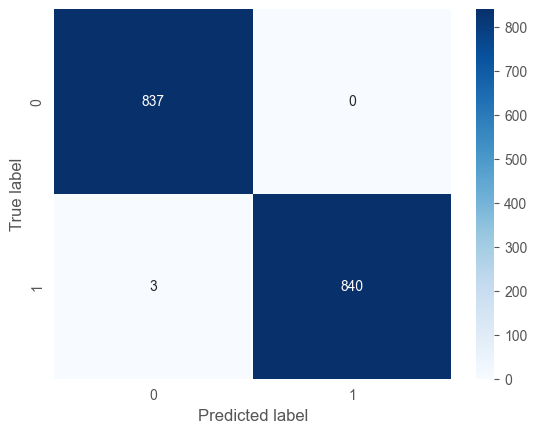

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       837
           1       1.00      1.00      1.00       843

    accuracy                           1.00      1680
   macro avg       1.00      1.00      1.00      1680
weighted avg       1.00      1.00      1.00      1680

Class train:
[0 0 0 ... 1 1 1]

Class predict:
[0 0 0 ... 1 1 1]


In [296]:
print('Accuracy:')
print(accuracy_score(predict, target))
print()
print('Confusion matrix:')
cm = sns.heatmap(confusion_matrix(predict, target), cmap='Blues', annot=True, fmt='d')
cm.set_xlabel('Predicted label')
cm.set_ylabel('True label')
plt.show()
print('Classification report:')
print(classification_report(predict, target))
print('Class train:')
print(predict)
print()
print('Class predict:')
print(target)

In [306]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="loss", mode ="min", patience=20, restore_best_weights=True)

In [307]:
history_valid = model.fit(train_data['mfcc'], transform_categorical_class(train_data['class'], 2),
                          validation_data=(valid_data['mfcc'], transform_categorical_class(valid_data['class'],2)),
                          batch_size=batch_size, epochs=epoch, callbacks=stop_early, verbose=True, shuffle=True)

Epoch 1/50
42/42 [==============================] - 8s 58ms/step - loss: 0.7672 - categorical_accuracy: 0.4952 - val_loss: 0.6888 - val_categorical_accuracy: 0.5450
Epoch 2/50
42/42 [==============================] - 2s 38ms/step - loss: 0.7568 - categorical_accuracy: 0.4970 - val_loss: 0.6886 - val_categorical_accuracy: 0.5250
Epoch 3/50
42/42 [==============================] - 2s 38ms/step - loss: 0.7218 - categorical_accuracy: 0.5286 - val_loss: 0.6859 - val_categorical_accuracy: 0.5325
Epoch 4/50
42/42 [==============================] - 2s 40ms/step - loss: 0.7175 - categorical_accuracy: 0.5440 - val_loss: 0.6830 - val_categorical_accuracy: 0.5700
Epoch 5/50
42/42 [==============================] - 2s 37ms/step - loss: 0.7062 - categorical_accuracy: 0.5613 - val_loss: 0.6797 - val_categorical_accuracy: 0.5875
Epoch 6/50
42/42 [==============================] - 2s 37ms/step - loss: 0.6914 - categorical_accuracy: 0.5750 - val_loss: 0.6780 - val_categorical_accuracy: 0.6225
Epoch 7/50

In [308]:
predict = np.argmax(model.predict(valid_data['mfcc']), axis=1)
target = np.argmax(transform_categorical_class(valid_data['class'], 2), axis=1)

13/13 [==============================] - 1s 12ms/step


Accuracy:
0.505

Confusion matrix:


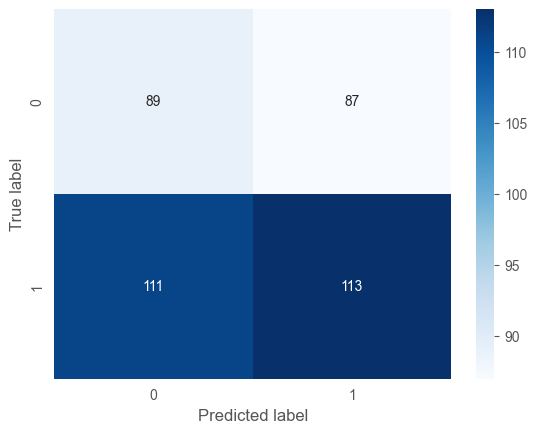

Classification report:
              precision    recall  f1-score   support

           0       0.45      0.51      0.47       176
           1       0.56      0.50      0.53       224

    accuracy                           0.51       400
   macro avg       0.51      0.51      0.50       400
weighted avg       0.51      0.51      0.51       400

Class predict:
[1 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1
 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0
 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 0 0 1 1
 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 1 0
 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 1 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 0
 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 1 1 0 1 1
 1 0 0 0 0 1 0 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 1 0 1
 1 1 1 0 0 0 0 1 1 0 0 0 1 0 1 1 0 

In [309]:
print('Accuracy:')
print(accuracy_score(predict, target))
print()
print('Confusion matrix:')
cm = sns.heatmap(confusion_matrix(predict, target), cmap='Blues', annot=True, fmt='d')
cm.set_xlabel('Predicted label')
cm.set_ylabel('True label')
plt.show()
print('Classification report:')
print(classification_report(predict, target))
print('Class predict:')
print(predict)
print()
print('Class true:')
print(target)

In [215]:
# Análisis y visualización del entrenamiento:

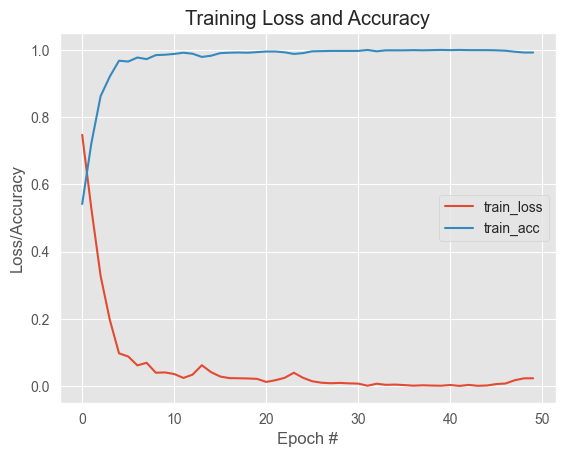

In [269]:
plt.figure()
plt.plot(np.arange(0, epoch), history_train.history["loss"], label="train_loss")
plt.plot(np.arange(0, epoch), history_train.history["categorical_accuracy"], label="train_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()
plt.clf()
plt.close()

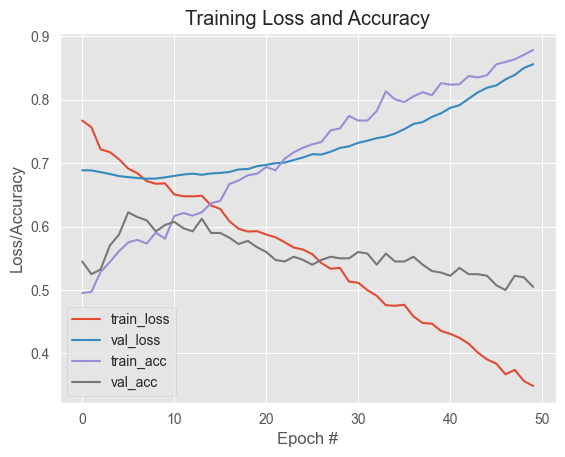

In [310]:
plt.figure()
plt.plot(np.arange(0, epoch), history_valid.history["loss"], label="train_loss")
plt.plot(np.arange(0, epoch), history_valid.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epoch), history_valid.history["categorical_accuracy"], label="train_acc")
plt.plot(np.arange(0, epoch), history_valid.history["val_categorical_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()
plt.clf()
plt.close()

In [218]:
# Evaluación final del modelo CNN:

In [278]:
test_data = {'mfcc': [], 'class': []}

In [279]:
test_data['mfcc'] = np.array(concat_mfcc([test['mfcc']]))
test_data['class'] = np.array(generate_class_by_index(test['class'], range(len(test['class'])), 40))

In [221]:
[str(key) + ': ' + str(len(test_data[key])) for key in test_data]

['mfcc: 880', 'class: 880']

In [311]:
predict = np.argmax(model.predict(test_data['mfcc']), axis=1)
target = np.argmax(transform_categorical_class(test_data['class'], 2), axis=1)

28/28 [==============================] - 0s 10ms/step


Accuracy:
0.553409090909091

Confusion matrix:


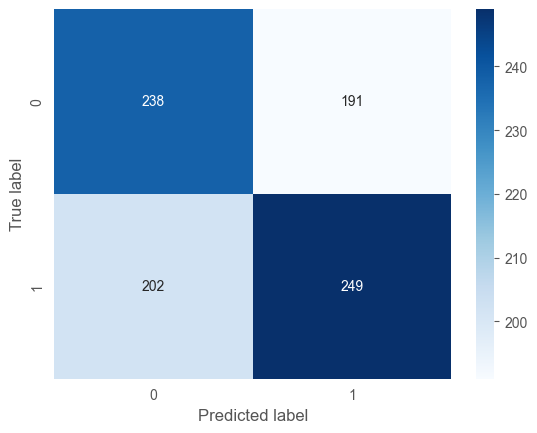

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.55      0.55       429
           1       0.57      0.55      0.56       451

    accuracy                           0.55       880
   macro avg       0.55      0.55      0.55       880
weighted avg       0.55      0.55      0.55       880

Class predict:
[1 1 1 0 0 0 1 0 1 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0
 1 1 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 0
 1 0 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0 0 1 1 1 1 1 0 1
 0 1 1 0 0 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1
 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1
 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 

In [312]:
print('Accuracy:')
print(accuracy_score(predict, target))
print()
print('Confusion matrix:')
cm = sns.heatmap(confusion_matrix(predict, target), cmap='Blues', annot=True, fmt='d')
cm.set_xlabel('Predicted label')
cm.set_ylabel('True label')
plt.show()
print('Classification report:')
print(classification_report(predict, target))
print('Class predict:')
print(predict)
print()
print('Class true:')
print(target)

In [ ]:
# Optimización de hiperparametros:

In [253]:
def build_model(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('conv_1_filter', min_value=32, max_value=512, step=32),
                     kernel_size=hp.Choice('conv_1_kernel', values=[1,2,3,4]),
                     strides=hp.Choice('conv_1_stride', values=[1,2,3,4]),
                     padding='same',
                     input_shape=(13, 393), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=hp.Choice('maxpool_1_size', values = [1,2]), padding='same'))

    model.add(Conv1D(filters=hp.Int('conv_2_filter', min_value=32, max_value=512, step=32),
                     kernel_size=hp.Choice('conv_2_kernel', values=[1,2,3,4]),
                     strides=hp.Choice('conv_2_stride', values=[1,2,3,4]),
                     padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=hp.Choice('maxpool_2_size', values=[2,4]), padding='same'))

    model.add(Conv1D(filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('conv_3_kernel', values=[1,2,3,4]),
                     strides=hp.Choice('conv_3_stride', values=[1,2,3,4]),
                     padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=hp.Choice('maxpool_3_size', values=[2,4,8]), padding='same'))

    model.add(Flatten())
    model.add(Dropout(0.3))

    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(units=hp.Int('units_3', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(units=hp.Int('units_4', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(units=hp.Int('units_5', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])), loss='categorical_crossentropy',
                  metrics=[categorical_accuracy])
    return model

In [254]:
tuner = kt.Hyperband(build_model,
                     objective=Objective("val_loss", direction="min"),
                     max_epochs=50,
                     factor=2,
                     directory='optimizer',
                     project_name='second',
                     hyperband_iterations=1,
                     overwrite=True,
                     seed=42)

In [255]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20)

In [257]:
tuner.search(train_data['mfcc'], transform_categorical_class(train_data['class'], 2),
             epochs=50, validation_split=0.19, callbacks=[stop_early])

Trial 295 Complete [00h 01m 37s]
val_loss: 0.8148061633110046

Best val_loss So Far: 0.5848857164382935
Total elapsed time: 02h 59m 47s
INFO:tensorflow:Oracle triggered exit


In [258]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [259]:
print(f"Numerous of filters of convolution of input: {best_hps.get('conv_1_filter')}")
print(f"Numerous of kernel of convolution of input: {best_hps.get('conv_1_kernel')}")
print(f"Numerous of stride of convolution of input: {best_hps.get('conv_1_stride')}")
print(f"Numerous of max pool of convolution of input: {best_hps.get('maxpool_1_size')}")
print(f"Numerous of filters of convolution of layer 1: {best_hps.get('conv_2_filter')}")
print(f"Numerous of kernel of convolution of layer 1: {best_hps.get('conv_2_kernel')}")
print(f"Numerous of stride of convolution of layer 1: {best_hps.get('conv_2_stride')}")
print(f"Numerous of max pool of convolution of layer 1: {best_hps.get('maxpool_2_size')}")
print(f"Numerous of filters of convolution of layer 2: {best_hps.get('conv_3_filter')}")
print(f"Numerous of kernel of convolution of layer 2: {best_hps.get('conv_3_kernel')}")
print(f"Numerous of stride of convolution of layer 2: {best_hps.get('conv_3_stride')}")
print(f"Numerous of max pool of convolution of layer 2: {best_hps.get('maxpool_3_size')}")
print(f"Numerous of unites of layer dense 1: {best_hps.get('units_1')}")
print(f"Numerous of unites of layer dense 2: {best_hps.get('units_2')}")
print(f"Numerous of unites of layer dense 3: {best_hps.get('units_1')}")
print(f"Numerous of unites of layer dense 4: {best_hps.get('units_2')}")
print(f"Numerous of unites of layer dense 5: {best_hps.get('units_1')}")
print(f"Value of learning rate optime: {best_hps.get('learning_rate')}")

Numerous of filters of convolution of input: 32
Numerous of kernel of convolution of input: 4
Numerous of stride of convolution of input: 3
Numerous of max pool of convolution of input: 1
Numerous of filters of convolution of layer 1: 352
Numerous of kernel of convolution of layer 1: 1
Numerous of stride of convolution of layer 1: 4
Numerous of max pool of convolution of layer 1: 2
Numerous of filters of convolution of layer 2: 96
Numerous of kernel of convolution of layer 2: 2
Numerous of stride of convolution of layer 2: 3
Numerous of max pool of convolution of layer 2: 8
Numerous of unites of layer dense 1: 480
Numerous of unites of layer dense 2: 480
Numerous of unites of layer dense 3: 480
Numerous of unites of layer dense 4: 480
Numerous of unites of layer dense 5: 480
Value of learning rate optime: 0.001
